In [27]:
import numpy as np
N =  int(73728)
D = N
A = np.zeros((N, D), dtype='float16')
print(f"Size of numpy array A: {A.nbytes / (1024 **3):.2f} GB. N: {N}")

Size of numpy array A: 10.12 GB. N: 73728


### Wizualizacja statystyk poszczególnych warstw

In [161]:
import pandas as pd

df = pd.read_parquet("/Users/jakubszafranski/Desktop/custom_activations_100_rows.parquet")
index = df.index

In [162]:
up_proj_df = df[df.index.str.contains('up_proj')]
index_up = up_proj_df.index

down_proj_df = df[df.index.str.contains('down_proj')]
index_down = down_proj_df.index

In [163]:
df = down_proj_df
index = df.index

In [164]:
import numpy as np
from scipy import stats

# Percentile normalization for each column
def percentile_normalize_columns(df):
    """Apply percentile normalization to each column - vectorized version"""
    normalized = np.zeros_like(df)
    
    for col in range(df.shape[1]):
        column_data = df[:, col]
        # Use argsort to get ranks, then convert to percentiles
        ranks = np.argsort(np.argsort(column_data))
        # Convert ranks to percentiles (0-1 range)
        normalized[:, col] = ranks / (len(column_data) - 1)
    
    return normalized

# Apply percentile normalization
df_normalized = percentile_normalize_columns(df.to_numpy())

df_normalized = df_normalized * 100
df_normalized = df_normalized.astype(int)

df_summary = pd.DataFrame(index=index, data=df_normalized)

In [165]:
layer_stats = {}

for layer in range(32):
    layer_mask = df_summary.index.str.contains(f'_{layer}_')
    layer_values = df_summary[layer_mask].to_numpy()
    layer_values = layer_values.flatten()

    layer_stats[layer] = {
        "mean": round(np.mean(layer_values), 2),
        "median": int(np.median(layer_values)),
        "mode": stats.mode(layer_values).mode
    }

In [166]:
for layer, stats in layer_stats.items():
    print(f"Layer {layer}:")
    print(f"  Mean: {stats['mean']}")
    print(f"  Median: {stats['median']}")
    print(f"  Mode: {stats['mode']}")

Layer 0:
  Mean: 2.09
  Median: 1
  Mode: 0
Layer 1:
  Mean: 6.16
  Median: 4
  Mode: 4
Layer 2:
  Mean: 9.16
  Median: 7
  Mode: 6
Layer 3:
  Mean: 12.46
  Median: 10
  Mode: 9
Layer 4:
  Mean: 15.9
  Median: 13
  Mode: 12
Layer 5:
  Mean: 19.26
  Median: 16
  Mode: 15
Layer 6:
  Mean: 22.66
  Median: 19
  Mode: 17
Layer 7:
  Mean: 25.95
  Median: 23
  Mode: 20
Layer 8:
  Mean: 28.3
  Median: 25
  Mode: 23
Layer 9:
  Mean: 31.15
  Median: 29
  Mode: 26
Layer 10:
  Mean: 33.09
  Median: 31
  Mode: 29
Layer 11:
  Mean: 34.99
  Median: 33
  Mode: 31
Layer 12:
  Mean: 37.08
  Median: 35
  Mode: 34
Layer 13:
  Mean: 40.56
  Median: 39
  Mode: 38
Layer 14:
  Mean: 43.25
  Median: 42
  Mode: 41
Layer 15:
  Mean: 47.09
  Median: 45
  Mode: 45
Layer 16:
  Mean: 50.31
  Median: 48
  Mode: 48
Layer 17:
  Mean: 54.11
  Median: 52
  Mode: 51
Layer 18:
  Mean: 57.13
  Median: 55
  Mode: 54
Layer 19:
  Mean: 59.83
  Median: 58
  Mode: 57
Layer 20:
  Mean: 62.88
  Median: 61
  Mode: 60
Layer 21:
  Me

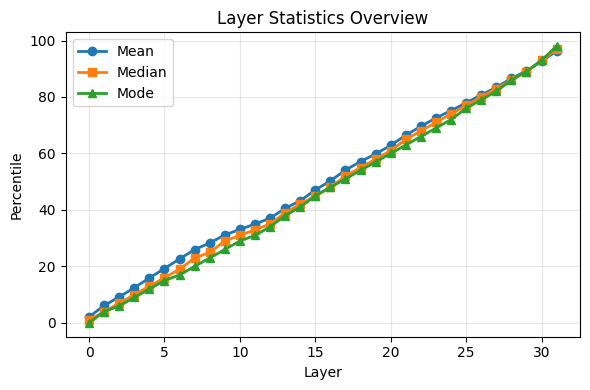

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
layers = list(layer_stats.keys())
means = [layer_stats[layer]['mean'] for layer in layers]
medians = [layer_stats[layer]['median'] for layer in layers]
modes = [layer_stats[layer]['mode'][0] if hasattr(layer_stats[layer]['mode'], '__len__') else layer_stats[layer]['mode'] for layer in layers]

# Create visualizations
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(layers, means, marker='o', label='Mean', linewidth=2)
ax.plot(layers, medians, marker='s', label='Median', linewidth=2)
ax.plot(layers, modes, marker='^', label='Mode', linewidth=2)
ax.set_xlabel('Layer')
ax.set_ylabel('Percentile')
ax.set_title('Layer Statistics Overview')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Inne

In [2]:
import pandas as pd

df = pd.read_parquet("grouping/custom_activations_100_rows.parquet", engine="fastparquet")
index = df.index

In [77]:
up_proj_df = df[df.index.str.contains('up_proj')]
index_up = up_proj_df.index

down_proj_df = df[df.index.str.contains('down_proj')]
index_down = down_proj_df.index

In [78]:
def get_layer_splits_percentile_normalized(df, threshold):
    def _transform_col_to_percentiles(df):
        return df.apply(lambda x: x.rank(pct=True) * 100, axis=0)

    def _binarize_df(df, threshold):
        return (df > threshold).astype(int)

    def _split_layers(df, threshold):
        dfs = {}

        for i in range(32):
            df_temp = pd.DataFrame()
            layer_mask = df.index.str.contains(f'_{i}_')
            layer_values = df[layer_mask]
            df_temp = pd.concat([df_temp, pd.DataFrame(layer_values)], axis=0)

            dfs[str(i)] = _binarize_df(_transform_col_to_percentiles(df_temp), threshold)

        return dfs
    

    up_proj_df = df[df.index.str.contains('up_proj')]
    down_proj_df = df[df.index.str.contains('down_proj')]

    return _split_layers(up_proj_df, threshold), _split_layers(down_proj_df, threshold)

threshold_percentile = 70
up_proj_dfs, down_proj_dfs = get_layer_splits_percentile_normalized(df, threshold=threshold_percentile)

In [79]:
df_all = pd.concat([up_proj_dfs[layer] for layer in up_proj_dfs] + [down_proj_dfs[layer] for layer in down_proj_dfs], axis=0)

In [80]:
import numpy as np


def dice_coefficient(col1, col2):
    intersection = np.sum((col1 == 1) & (col2 == 1))
    cardinality = np.sum(col1 == 1) + np.sum(col2 == 1)
    if cardinality == 0:
        return 1.0
    return 2 * intersection / cardinality

def jaccard_coefficient(col1, col2):
    intersection = np.sum((col1 == 1) & (col2 == 1))
    union = np.sum((col1 == 1) | (col2 == 1))
    if union == 0:
        return 1.0
    return intersection / union

def hamming_distance(col1, col2):
    return np.sum(col1 == col2) / len(col1)

the_biggest_dice_score = 0
the_smallest_dice_score = float('inf')
for i in range(10):
    for j in range(10):
        if i == j:
            continue
        dice_score = hamming_distance(df_all[f'text_{i}'], df_all[f'text_{j}'])
        if dice_score > the_biggest_dice_score:
            the_biggest_dice_score = dice_score
            indices = (i, j)
        if dice_score < the_smallest_dice_score:
            the_smallest_dice_score = dice_score
            indices_smallest = (i, j)


print(f"The biggest Dice coefficient is: {the_biggest_dice_score:.4f} between text_{indices[0]} and text_{indices[1]}")
print(f"The smallest Dice coefficient is: {the_smallest_dice_score:.4f} between text_{indices_smallest[0]} and text_{indices_smallest[1]}")

The biggest Dice coefficient is: 0.8201 between text_3 and text_8
The smallest Dice coefficient is: 0.7370 between text_2 and text_7


In [23]:
def get_layer_splits(df, threshold):

    def _split_layers(df, threshold):
        dfs = {}

        for i in range(32):
            df_temp = pd.DataFrame()
            layer_mask = df.index.str.contains(f'_{i}_')
            layer_values = df[layer_mask]
            df_temp = pd.concat([df_temp, pd.DataFrame(layer_values)], axis=0)

            dfs[str(i)] = df_temp

        return dfs
    

    up_proj_df = df[df.index.str.contains('up_proj')]
    down_proj_df = df[df.index.str.contains('down_proj')]

    return _split_layers(up_proj_df, threshold), _split_layers(down_proj_df, threshold)

threshold_percentile = 70
up_proj_dfs, down_proj_dfs = get_layer_splits(df, threshold=threshold_percentile)

50th percentile (median): 0.0494
60th percentile: 0.0543
70th percentile: 0.0604
Mean value: 0.0626
Percentage above mean: 26.99%
Percentage above 50th percentile: 49.96%
Percentage above 60th percentile: 39.95%
Percentage above 70th percentile: 30.00%


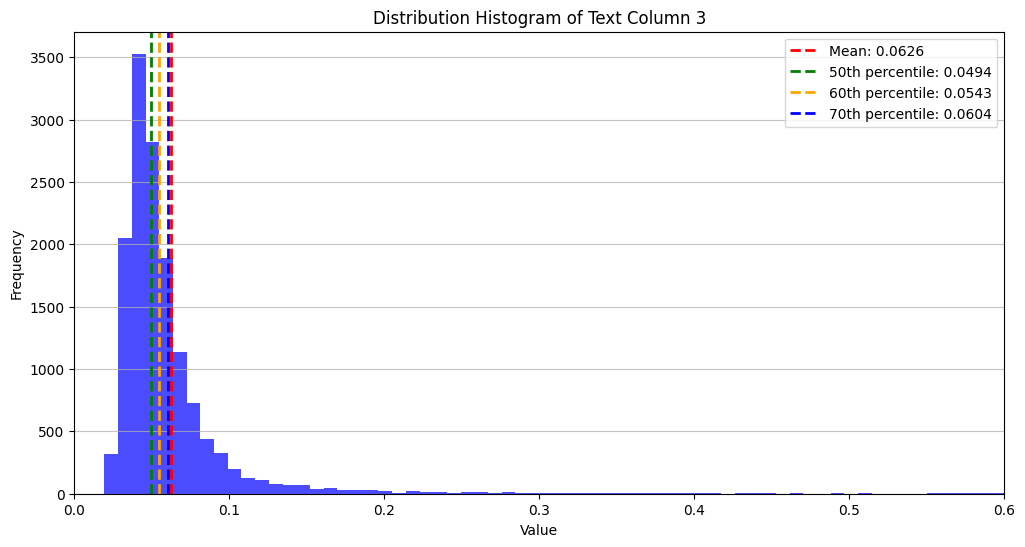

In [45]:
import matplotlib.pyplot as plt
# PLOT DISTRIBUTION HISTOGRAM OF VALUES
df_show = up_proj_dfs['0'].copy()["text_7"]

# Calculate percentiles
percentile_50 = df_show.quantile(0.50)  # 50th percentile (median)
percentile_60 = df_show.quantile(0.60)  # 60th percentile
percentile_70 = df_show.quantile(0.70)  # 70th percentile
mean = df_show.mean()
percentile_90 = df_show.quantile(0.99)
# df_show = df_show.apply(lambda x: x if x < percentile_90 else percentile_90)

# Print percentile values
print(f"50th percentile (median): {percentile_50:.4f}")
print(f"60th percentile: {percentile_60:.4f}")
print(f"70th percentile: {percentile_70:.4f}")
print(f"Mean value: {df_show.mean():.4f}")

# Calculate percentage above mean
print(f"Percentage above mean: {df_show.apply(lambda x: 1 if x > mean else 0).mean():.2%}")
print(f"Percentage above 50th percentile: {df_show.apply(lambda x: 1 if x > percentile_50 else 0).mean():.2%}")
print(f"Percentage above 60th percentile: {df_show.apply(lambda x: 1 if x > percentile_60 else 0).mean():.2%}")
print(f"Percentage above 70th percentile: {df_show.apply(lambda x: 1 if x > percentile_70 else 0).mean():.2%}")

plt.figure(figsize=(12, 6))

# Add vertical lines for percentiles
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.4f}')
plt.axvline(percentile_50, color='green', linestyle='dashed', linewidth=2, label=f'50th percentile: {percentile_50:.4f}')
plt.axvline(percentile_60, color='orange', linestyle='dashed', linewidth=2, label=f'60th percentile: {percentile_60:.4f}')
plt.axvline(percentile_70, color='blue', linestyle='dashed', linewidth=2, label=f'70th percentile: {percentile_70:.4f}')

plt.hist(df_show, color='blue', alpha=0.7, bins=1000)
plt.xlabel('Value')
plt.xlim(0, 0.6)

plt.ylabel('Frequency')
plt.title('Distribution Histogram of Text Column 3')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

### New Era

In [9]:
import json
import numpy as np

with open("cluster_masks_up.json", 'r') as f:
    CLUSTER_MASKS = json.load(f)

with open("cluster_layer_mapping_up.json", 'r') as f:
    CLUSTER_LAYER_MAPPING = json.load(f)


def reduce_logical_or(array: np.ndarray) -> np.ndarray:
    return np.logical_or.reduce(array, axis=0)


def get_pruning_mask(clusters_to_prune: list[str], layer: str) -> np.ndarray:
    up_projs = []
    down_projs = []
    for cluster in clusters_to_prune:
        if layer in CLUSTER_LAYER_MAPPING[cluster]:
            up_projs.append(CLUSTER_MASKS["up_proj"][layer][cluster])
            down_projs.append(CLUSTER_MASKS["down_proj"][layer][cluster])

    up_proj = 1 - reduce_logical_or(np.stack(up_projs, axis=0))
    down_proj = 1 - reduce_logical_or(np.stack(down_projs, axis=0))
    return up_proj, down_proj


import torch
def get_pruning_mask(clusters_to_prune: list[str], layer: str) -> np.ndarray:
    up_projs = []
    down_projs = []
    for cluster in clusters_to_prune:
        if layer in CLUSTER_LAYER_MAPPING[cluster]:
            up_projs.append(CLUSTER_MASKS["up_proj"][layer][cluster])
            # down_projs.append(CLUSTER_MASKS["down_proj"][layer][cluster])

    if not up_projs:
        return torch.ones((14336,), dtype=torch.bool)
    up_proj = 1 - reduce_logical_or(np.stack(up_projs, axis=0))
    # down_proj = 1 - reduce_logical_or(np.stack(down_projs, axis=0))
    # return up_proj, down_proj
    # make it torch
    return torch.tensor(up_proj, dtype=torch.bool)

In [19]:
import time

# measure time of get_pruning_mask
times = []
clusters = CLUSTER_LAYER_MAPPING.keys()
for _ in range(1000):
    start = time.perf_counter()
    get_pruning_mask(clusters, str(np.random.randint(0, 32)))
    end = time.perf_counter()
    times.append(end - start)

print(f"Average time: {sum(times) / len(times)}")

Average time: 0.006472878655797104


In [ ]:
import torch

A = torch.randn(14336, 4096)

In [35]:
masks = [np.random.randint(0, 14336, size=(i)) for i in [1024, 2048, 4096, 8192, 13000]]

In [46]:
import torch
import time
import numpy as np

A = torch.randn(14336, 4096).T
B = torch.randn(14336, 4096)

In [48]:
times = []
for _ in range(10):
    start = time.perf_counter()
    A @ B
    end = time.perf_counter()
    times.append(end - start)
print(f"Average time: {sum(times) / len(times):.6f}s")

# pruning 20%
A = A[:int(0.8 * A.shape[0]), :]
B = B[:, :int(0.8 * B.shape[0])]
times = []
for _ in range(10):
    start = time.perf_counter()
    A @ B
    end = time.perf_counter()
    times.append(end - start)
print(f"Average time after pruning 20%: {sum(times) / len(times):.6f}s")

Average time: 0.568154s
Average time after pruning 20%: 0.453864s


In [1]:
import torch
import torch.nn as nn
import time
import random
import numpy as np

# Simulate Llama3 8B MLP structure
class MLPLayer(nn.Module):
    def __init__(self):
        super().__init__()
        size_small = 128
        size_large = 512
        self.gate_proj = nn.Linear(size_small, size_large, bias=False)
        self.up_proj = nn.Linear(size_small, size_large, bias=False)
        self.down_proj = nn.Linear(size_large, size_small, bias=False)

class FakeLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = MLPLayer()

class FakeLlama(nn.Module):
    def __init__(self, num_layers=32):
        super().__init__()
        self.model = nn.Module()
        self.model.layers = nn.ModuleList([FakeLayer() for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.model.layers:
            gate = layer.mlp.gate_proj(x)
            gate = torch.sigmoid(gate)
            up = layer.mlp.up_proj(x)
            mlp_out = gate * up
            mlp_out = layer.mlp.down_proj(mlp_out)
            x = x + mlp_out  # Residual connection
        return torch.sigmoid(x).mean()

# Simulate pruning masks (keeping 50% of neurons)
def get_pruning_mask(layer_idx):
    keep_count = 512 // 2  # Keep 50%
    mask = torch.zeros(512, dtype=torch.bool)
    keep_indices = random.sample(range(512), keep_count)
    mask[keep_indices] = True
    return mask

def prune_mlp_layer(model):
    """Ultra-fast in-place pruning - directly modify weight tensors with timing."""
    times_per_layer = []
    t_total_start = time.perf_counter()

    for layer_index, layer in enumerate(model.model.layers):
        t_layer_start = time.perf_counter()

        keep_inter = get_pruning_mask(layer_index)
        mlp = layer.mlp

        # measure slicing time
        t_slice_start = time.perf_counter()
        w_gate = mlp.gate_proj.weight.data[keep_inter, :]
        w_up = mlp.up_proj.weight.data[keep_inter, :]
        w_down = mlp.down_proj.weight.data[:, keep_inter]
        t_slice_end = time.perf_counter()

        # assign sliced tensors back
        t_assign_start = time.perf_counter()
        mlp.gate_proj.weight.data = w_gate
        mlp.up_proj.weight.data = w_up
        mlp.down_proj.weight.data = w_down
        t_assign_end = time.perf_counter()

        # Update dimensions
        new_size = keep_inter.sum().item()
        mlp.gate_proj.out_features = new_size
        mlp.up_proj.out_features = new_size
        mlp.down_proj.in_features = new_size

        t_layer_end = time.perf_counter()
        layer_time = t_layer_end - t_layer_start
        times_per_layer.append(layer_time)

        if layer_index % 8 == 0:
            print(
                f"Layer {layer_index}: {512} -> {new_size} | "
                f"total: {layer_time:.6f}s, slice: {t_slice_end - t_slice_start:.6f}s, "
                f"assign: {t_assign_end - t_assign_start:.6f}s"
            )

    t_total_end = time.perf_counter()
    total_time = t_total_end - t_total_start
    avg_time = float(np.mean(times_per_layer)) if times_per_layer else 0.0
    print(f"Pruning total time: {total_time:.6f}s | avg per layer: {avg_time:.6f}s")

    return model

In [2]:
# Create model and measure
print("Creating model...")
model = FakeLlama(num_layers=32)

Creating model...


In [ ]:
from pruning.prunable_llm import PrunableLLM

prunable_llm = PrunableLLM(model)

/Users/jakubszafranski/anaconda3/envs/llm_pruning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
input = torch.ones(100, 128)
times = []
out = None
with torch.no_grad():
    for _ in range(100):
        start = time.perf_counter()
        out = prunable_llm(input)
        end = time.perf_counter()
        times.append(end - start)

t = torch.tensor(times)
print(f"Mean time: {t.mean().item():.6f}s, std: {t.std(unbiased=False).item():.6f}s, output: {out}")

# not pruned: Mean time: 0.007336s, std: 0.000450s, output: 0.6751129627227783
# pruned: Mean time: 0.003518s, std: 0.000714s, output: 0.7182592749595642
# pruned undo: Mean time: 0.007022s, std: 0.001434s, output: 0.6946258544921875

Mean time: 0.006758s, std: 0.003952s, output: 0.6820452213287354


In [8]:
prunable_llm.prune(mask_fn=get_pruning_mask)

In [6]:
prunable_llm.undo_prune()

In [67]:
original_params = sum(p.numel() for p in model.parameters())
print(f"Original parameters: {original_params:,}")

print("\nPruning model...")
start_time = time.time()
pruned_model = prune_mlp_layer(model)
end_time = time.time()

pruned_params = sum(p.numel() for p in pruned_model.parameters())
reduction = 100 * (1 - pruned_params / original_params)

print(f"\nPruning completed in {end_time - start_time:.2f} seconds")
print(f"Pruned parameters: {pruned_params:,}")
print(f"Reduction: {reduction:.2f}%")

Original parameters: 6,291,456

Pruning model...
Layer 0: 512 -> 256 | total: 0.001324s, slice: 0.000768s, assign: 0.000016s
Layer 8: 512 -> 256 | total: 0.000385s, slice: 0.000216s, assign: 0.000008s
Layer 16: 512 -> 256 | total: 0.000820s, slice: 0.000239s, assign: 0.000009s
Layer 24: 512 -> 256 | total: 0.000356s, slice: 0.000190s, assign: 0.000008s
Pruning total time: 0.015680s | avg per layer: 0.000484s

Pruning completed in 0.02 seconds
Pruned parameters: 3,145,728
Reduction: 50.00%


In [83]:
model.eval() 

input = torch.ones(1, 128)

model(input)

tensor(0.6976, grad_fn=<MeanBackward0>)

In [ ]:
# tensor(0.6985, grad_fn=<MeanBackward0>)
# pruned: tensor(0.6869, grad_fn=<MeanBackward0>)

In [ ]:
undo_pack = prune_with_undo_pack(model, mask_fn=lambda i: get_pruning_mask(i), storage="cpu")

unprune_from_undo_pack(model, undo_pack)


In [89]:
model(input)

tensor(0.6976, grad_fn=<MeanBackward0>)

In [88]:
unprune_from_undo_pack(model, undo_pack)


In [48]:
### how much total pruning

In [1]:
down = 32 *14336 * 4096
up = 32 *2 * 4096 * 14336
mlp =  down + up
whole = 8000000000
mlp / whole

0.704643072

In [2]:
(up *0.5)/whole

0.234881024

In [4]:
0.20525251116071427 * mlp / up

0.30787876674107145

In [1]:
# from transformers lib datasets import wikitext 

from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
print(dataset[0])

/Users/jakubszafranski/anaconda3/envs/llm_pruning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 3760/3760 [00:00<00:00, 1310066.71 examples/s]

{'text': ''}


In [4]:
from transformers import AutoTokenizer
from datasets import load_dataset
import re
import numpy as np

# Load tokenizer (adjust path if needed)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")

# Load dataset (using the document-level version from your code)
dataset = load_dataset("EleutherAI/wikitext_document_level", "wikitext-2-raw-v1", split="test")

# Detokenize function (from your data_source.py)
def wikitext_detokenizer(text: str) -> str:
    string = text
    string = string.replace("s '", "s'")
    string = re.sub(r"/' [0-9]/", r"/'[0-9]/", string)
    string = string.replace(" @-@ ", "-")
    string = string.replace(" @,@ ", ",")
    string = string.replace(" @.@ ", ".")
    string = string.replace(" : ", ": ")
    string = string.replace(" ; ", "; ")
    string = string.replace(" . ", ". ")
    string = string.replace(" ! ", "! ")
    string = string.replace(" ? ", "? ")
    string = string.replace(" , ", ", ")
    string = re.sub(r"\(\s*([^\)]*?)\s*\)", r"(\1)", string)
    string = re.sub(r"\[\s*([^\]]*?)\s*\]", r"[\1]", string)
    string = re.sub(r"{\s*([^}]*?)\s*}", r"{\1}", string)
    string = re.sub(r"\"\s*([^\"]*?)\s*\"", r'"\1"', string)
    string = re.sub(r"'\s*([^']*?)\s*'", r"'\1'", string)
    string = string.replace("= = = =", "====")
    string = string.replace("= = =", "===")
    string = string.replace("= =", "==")
    string = string.replace(" " + chr(176) + " ", chr(176))
    string = string.replace(" \n", "\n")
    string = string.replace("\n ", "\n")
    string = string.replace(" N ", " 1 ")
    string = string.replace(" 's", "'s")
    return string

# Compute token lengths
token_lengths = []
for item in dataset:
    text = wikitext_detokenizer(item["page"])
    tokens = tokenizer(text, add_special_tokens=True)["input_ids"]
    token_lengths.append(len(tokens))

print(
    f"Average token length: {sum(token_lengths) / len(token_lengths):.2f} std: {np.std(token_lengths):.2f}"
    f"Min: {min(token_lengths)} Max: {max(token_lengths)}"
    f"Median: {np.median(token_lengths)} Mode: {max(set(token_lengths), key=token_lengths.count)}"
)

Average token length: 4430.76 std: 3742.09Min: 30 Max: 15347Median: 2926.5 Mode: 3064


In [5]:
9/7

1.2857142857142858